# Geometric Median as the Optimal Location for a Substation for a given Collection System

## Problem Description

For a given wind farm layout with turbine locations $T$ and a collection system with initial circuit locations $C$ and grid connection $\mathbf{g}$, we must find a substation location $\mathbf{s}$ that minimizes the sum of the cabling cost required to connect the circuits to the substation and the substation to the grid connection point. The general problem formulation can be expressed as follows:

$$\mathbf{s} = arg min_\mathbf{s}(\sum_{i=1}^{m} ||\mathbf{C_i}- \mathbf{s}|| + ||\mathbf{s} - \mathbf{g}||) $$

where $m$ denotes the total number of circuit endpoints. 

It must be noted that for a given wind farm layout, the collection system can take different forms as it optimality depends on the location of the substation. Thus, the problem of the substation and collection design is a coupled one. This attempt will take an iterative approach and will assume an initial collection system and circuit endpoints (which themselves can be chosen diferently depending on the substation location). 

With this in mind, the innermost loop of our iterative approach consists of finding the <a href=http://en.wikipedia.org/wiki/Geometric_median>Geometric Median</a> of the circuit endpoints and a weighted grid connection point.

## Computation

From the above referenced article, we find that the computation of the Geometric Median "has been shown that no explicit formula, nor an exact algorithm involving only arithmetic operations and kth roots can exist in general". The article also points to Weiszfeld's algorithm as a common approach to solve the problem. The method can be expressed as follows: 

$$y_{i+1} = (\sum_{k=1}^p \frac{x_j}{||x_j-y_i||})/(\sum_{k=1}^p \frac{1}{||x_j-y_i||})$$

The first pass of this problem will be a simple implementation of the Weiszfeld's algorithm. It has been noted, however, that this problem is convex. Thus, in the second implementation we will use a Convex Optimization library called <a href=http://cvxopt.org/index.html>CVXOPT</a>. Finally, we will use whichever implementation turns out to be faster for the final build. Additionally, we will generalize the original problem to:

$$\sum_{i=1}^n w_i||x_i - y||$$

and the iterative solution:

$$y_{i+1} = (\sum_{k=1}^p \frac{w_ix_j}{||x_j-y_i||})/(\sum_{k=1}^p \frac{w_i}{||x_j-y_i||})$$

in this case, the weight $w_i$ of each point will be $1$ except for the point corresponding to the grid connection. A future sophistication will involve using the appropiate weight for the given cable (based on capital cost and energy loss). Henceforth we will assume that the first entry of $\mathbf{X}$ is the grid connection point.

## Weiszfeld's Algorithm Implementation

As stated the problem will convert the set of circuit endpoints and the grid connection to a $\mathbf{X}_{(n+1)\times2}$ matrix with the first row representing the substation. Additionally, we have $\mathbf{w}$ which has the weights and $y$ which is our substation estimate.

First, let's import all required libraries.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (16, 10)

Now, we need to create a function that takes a set of locations and a grid connection
\position and returns $\mathbf{X}$ and a function that takes the weight estimated for the grid connection cable and returns our $w$.

In [2]:
def create_point_matrix(grid,circuits,gridWeight):
    #note: grid connection should be of the form [x,y]
    #note: circuits should be of the form [[x,y],[a,b]]
    #note: grid weight is a scalar
    x = np.concatenate(((np.array([grid],dtype=np.float32)),np.array(circuits,dtype=np.float32)))
    w = np.ones(x.shape[0])
    w[0] = gridWeight
    w = np.diag(w)
    return x,w


Now that we are able to create our input variables we need to create the  actual algortihm. The process consists of giving an initial guess and then gradually improving according to Weiszfeld's algorithm. We will provide the center of mass as the initial guess (and we expect it to be a fairly good one). Additionally, we will take an optional argument that specifies the stopping point (based on proportional improvement).

In [3]:
def sum_of_distances(X,W,y):
    return np.sum(np.dot(W,np.linalg.norm((X-y),axis=1)))

def new_point(X,W,y):
    #get the top
    topNumerator = np.dot(W,X)
    topDenominator = np.linalg.norm(X-y,axis=1)
    top = np.sum(np.divide(topNumerator.transpose(),topDenominator).transpose(),axis=0)
    bottom = np.sum(np.divide(W,topDenominator))
    yNew = top/bottom
    return yNew
    

def weiszfeld(X,W,stop=0.0001):
    #get the first guess
    y = np.sum(X,axis=0)/len(X)
    f = sum_of_distances(X,W,y)
    diff = 1.0
    while diff > stop:
        yNew = new_point(X,W,y)
        fNew = sum_of_distances(X,W,yNew)
        diff = np.absolute(f-fNew)/f
        y = yNew
        f = fNew
    return y
    

With this basic code we should be able to test our implementation.

## Testing Weiszfeld's Algorithm

As a first test we will provide a known (arbitrary) set of four circuit end points and a grid connection point. Later, we will try several near location to see if our algorithm did get as close as possible to the optimum.

In [4]:
#Define our arbitrary points
grid = [10.0,10.0]
circuits = [[1.,1.],[1.,2.],[1.,3.],[1.,4.],[1.,5.],[1.,6.],[1.,7.],[1.,8.],[1.,9.]]
gridWeight = 2.

In [5]:
#Get our X and W
x,w = create_point_matrix(grid,circuits,gridWeight)

In [6]:
#find the ideal point
optimum = weiszfeld(x,w)

In [7]:
optimum

array([ 1.28127204,  5.47754765])

Now we have a working implementation of Weisfeld's. Let's draw a contour to see how it compares to the surrounding area.

/home/ramon/development/notebooks/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


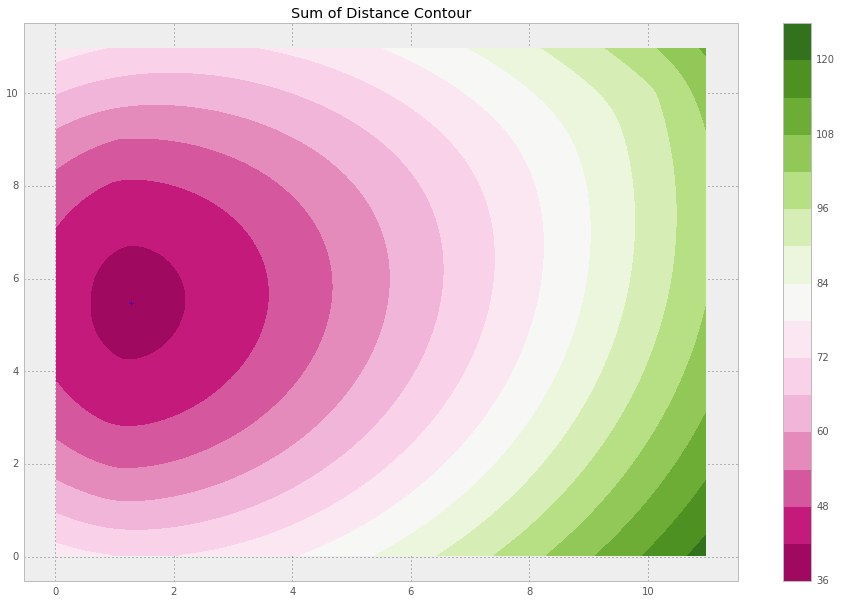

In [8]:
# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
u, v = np.mgrid[slice(0, 11 + dy, dy),
                slice(0, 11 + dx, dx)]

z = np.zeros((len(u),len(v)))

for i in range(len(z)):
    for j in range(len(z[i])):
        p = np.array([v[i][j],u[i][j]])
        z[i][j] = sum_of_distances(x,w,p)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


#plt.subplot(2, 1, 2)
# contours are *point* based plots, so convert our bound into point
# centers
plt.contourf(v[:-1, :-1] + dx / 2.,
             u[:-1, :-1] + dy / 2., z, levels=levels,
             cmap=cmap)
plt.colorbar()
plt.title('Sum of Distance Contour')
plt.scatter(optimum[0],optimum[1],marker="+")

plt.show()

As seen in the plot above, our result is very well positioned. Further tests should include more complex positioning, test for speed as the number of points increases, and how much better this is than simply estimating the center of mass.